# Modelling Data Using Machine Learning Techniques

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from datetime import date, datetime

In [2]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

### Importing Data

In [3]:
umg_data = pd.read_csv('final_merged_data.csv')
umg_data.head()

,spotify_id,label_studio,content_provider_name,major_label,original_release_date,genre_name,isrc_weekly_streams,artist_name,song_name,danceability,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,spotify_popularity
0,3eekarcy7kvN4yt5ZFzltW,Sony Music Labels Inc.,BMG,Sony,4/8/2020,Pop,6988609.870,Travis Scott,Highest in the Room,0.598,...,-8.764,0,0.0317,0.05460,0.000006,0.210,0.0605,76.469,175721,85
1,3frUvGrmGcay91lvFbOgsN,Kygo Music,Ultra,Sony,3/27/2020,Dance,5405228.712,"Kygo, Zara Larsson & Tyga",Like It Is,0.794,...,-6.759,1,0.1140,0.12100,0.000009,0.227,0.3600,105.024,183067,71
2,6tCssnvTUREcperDOUTqvA,JYP Entertainment,JYPEntertainment,Other,3/9/2020,Dance,3858453.691,ITZY,WANNABE,0.809,...,-4.410,0,0.0617,0.00795,0.000179,0.181,0.6400,122.035,191242,77
3,4tcPIwy0UvLYjhXLrMyx89,Armada Music,Armada,Other,3/12/2020,House,2301643.868,Endor,Pump It Up,0.898,...,-7.255,1,0.2250,0.20700,0.000093,0.061,0.6530,129.047,150635,61
4,3uc8AGNL0KbvISIrjnfRvN,Lauv,trafficinc,Other,3/6/2020,Pop,2193457.126,Lauv,Mean It (feat. Lany),0.746,...,-8.543,1,0.0872,0.04070,0.000000,0.172,0.3360,95.998,232853,73


In [4]:
## creating a new outcome variable called popularity
# For this variable a song is popular if it scores above 30 for spotify_popularity index
umg_data.loc[umg_data['spotify_popularity'] > 50, 'popular'] = 'Yes'
umg_data.loc[umg_data['spotify_popularity'] <= 50, 'popular'] = 'No'

In [5]:
## Creating an age variable
# the age variable calculates the age of the song from today's date
umg_data['original_release_date'] = pd.to_datetime(umg_data['original_release_date'])
umg_data['today_date'] = date.today()
umg_data['today_date'] = pd.to_datetime(umg_data['today_date'])
umg_data['age'] = umg_data['today_date'].sub(umg_data['original_release_date'], axis=0)
umg_data['age'] = (umg_data.age/np.timedelta64(1, 'D')).astype(int)

In [6]:
umg_data.columns
umg_data_model = umg_data[[
    'danceability', 'energy', 'key', 'loudness', 'speechiness', 'acousticness', 
         'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'age', 'popular'
         ]]
umg_data_model.head()

,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,age,popular
0,0.598,0.427,7,-8.764,0.0317,0.05460,0.000006,0.210,0.0605,76.469,175721,455,Yes
1,0.794,0.728,1,-6.759,0.1140,0.12100,0.000009,0.227,0.3600,105.024,183067,467,Yes
2,0.809,0.911,6,-4.410,0.0617,0.00795,0.000179,0.181,0.6400,122.035,191242,485,Yes
3,0.898,0.893,1,-7.255,0.2250,0.20700,0.000093,0.061,0.6530,129.047,150635,482,Yes
4,0.746,0.450,7,-8.543,0.0872,0.04070,0.000000,0.172,0.3360,95.998,232853,488,Yes


In [7]:
umg_data_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46961 entries, 0 to 46960
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   danceability      46961 non-null  float64
 1   energy            46961 non-null  float64
 2   key               46961 non-null  int64  
 3   loudness          46961 non-null  float64
 4   speechiness       46961 non-null  float64
 5   acousticness      46961 non-null  float64
 6   instrumentalness  46961 non-null  float64
 7   liveness          46961 non-null  float64
 8   valence           46961 non-null  float64
 9   tempo             46961 non-null  float64
 10  duration_ms       46961 non-null  int64  
 11  age               46961 non-null  int64  
 12  popular           46961 non-null  object 
dtypes: float64(9), int64(3), object(1)
memory usage: 4.7+ MB


## KNN model

In [8]:
#importing libraries
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


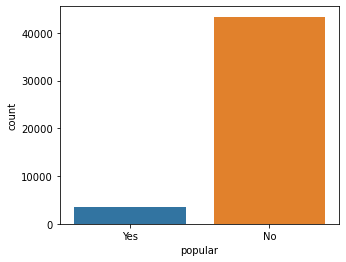

In [9]:
#checking distribution of popular and non-popular songs
plt.figure(figsize=(5,4))
sns.countplot(umg_data_model['popular']);

From the above chart, it looks like there is an unequal distribution of popular and non-popular songs. 

### splitting data into training and test sets

In [10]:
features = ['danceability', 'energy', 'key', 'loudness', 'speechiness', 'acousticness', 
         'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'age']

X = umg_data_model[features]
y = umg_data_model['popular']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)

#scaling the features
X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)

In [11]:
# fitting the model
knn = KNeighborsClassifier(n_neighbors=8)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=8)

In [12]:
y_pred = knn.predict(X_test)

In [13]:
result = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(result)
result2 = classification_report(y_test, y_pred)
print('\nClassification Report:')
print(result2)
result3 = accuracy_score(y_test, y_pred)
print("Accuracy: ", result3)

Confusion Matrix:
[[8661    5]
 [ 725    2]]

Classification Report:
              precision    recall  f1-score   support

          No       0.92      1.00      0.96      8666
         Yes       0.29      0.00      0.01       727

    accuracy                           0.92      9393
   macro avg       0.60      0.50      0.48      9393
weighted avg       0.87      0.92      0.89      9393

Accuracy:  0.9222825508357287


Although the accuracy of our model is about 92 percent. The accuracy canbe misleading. For UMG, the usefulness of our model would be in predicting the few songs that have the potential to be popular. The model above does well in predicting None popular songs since they are the most in our data, but does poorly in predicting popular songs since they are rare. We need to improve to predict the rare popular songs.

### Trying SMOTE to oversample rare class

In [14]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

In [15]:
over = SMOTE(sampling_strategy=0.3)
under = RandomUnderSampler(sampling_strategy=0.5)
X,y = over.fit_resample(X,y)
X,y = under.fit_resample(X,y)

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


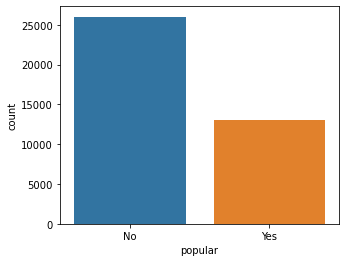

In [16]:
plt.figure(figsize=(5,4))
sns.countplot(y);

### Retraining Knn model of Resampled Data

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)

#scaling the features
X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)

knn = KNeighborsClassifier(n_neighbors=8)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

result = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(result)
result2 = classification_report(y_test, y_pred)
print('\nClassification Report:')
print(result2)
result3 = accuracy_score(y_test, y_pred)
print("Accuracy: ", result3)

Confusion Matrix:
[[4402  848]
 [1218 1338]]

Classification Report:
              precision    recall  f1-score   support

          No       0.78      0.84      0.81      5250
         Yes       0.61      0.52      0.56      2556

    accuracy                           0.74      7806
   macro avg       0.70      0.68      0.69      7806
weighted avg       0.73      0.74      0.73      7806

Accuracy:  0.7353317960543172


Although our accuracy reduced, the precision level, recall and f1-score improved for the Rare popular songs. Now we can predict the Rare popular songs better than before. It would be instructive to try other models like decision trees using our newly resample data and see how well it does.

### Hyperperameter Tuning

In the hyperparameter tuning phase, we will try to find the best leaf_size, n_neighbors, p and see how if we can find the optimal that can improve our model

In [18]:
leaf_size = list(range(1,50))
n_neighbors = list(range(1,25))
p=[1,2]

In [ ]:
hyperparams = dict(leaf_size=leaf_size, n_neighbors = n_neighbors, p=p)

#instantiating knn
knn_2 = KNeighborsClassifier()

# using gridsearch and doing 10 ten fold cross validation
clf = GridSearchCV(knn_2, hyperparams, cv=10)

#fitting model
best_model = clf.fit(X,y)

#Showing results
print('Best leaf_size:', best_model.best_estimator_.get_params()['leaf_size'])
print('Best p:', best_model.best_estimator_.get_params()['p'])
print('Best n_neighbors:', best_model.best_estimator_.get_params()['n_neighbors'])

In [ ]:
## re-writing model using the new parameters
knn = KNeighborsClassifier(n_neighbors=2, leaf_size=2, p=1)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

result = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(result)
result2 = classification_report(y_test, y_pred)
print('\nClassification Report:')
print(result2)
result3 = accuracy_score(y_test, y_pred)
print("Accuracy: ", result3)

### Decision Tree/Resampled Data

In [18]:
def fit_decision_tree_classifier(X, y):

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 46)

    dt_clf = DecisionTreeClassifier(criterion="entropy", max_depth = 50)
    
    #fit
    dt_clf.fit(X_train,y_train)

    #predict
    y_preds = dt_clf.predict(X_test)
    y_preds_prob = dt_clf.predict_proba(X_test)
    
    #score
    mat = confusion_matrix(y_test, y_preds)
    print(mat)
    print(sns.heatmap(mat, annot=True, cmap='bwr', linewidths=.5))
    acc = accuracy_score(y_test, y_preds)
    print(acc)

    #For cross validation
    print('')
    cv_score = cross_val_score(dt_clf, X, y, cv=10)
    print('*************CV Scores*************')
    print(cv_score)
    print(np.mean(cv_score))
    
    print('')
    print('Sensitivity-Specificity')
    tn, fp, fn, tp = confusion_matrix(y_test, y_preds).ravel()
    print(tn, fp, fn, tp)
    
    spec = tn/(tn+fp)
    sens = tp/(tp+fn)
    
    print(spec, sens)

    return acc

[[3951 1200]
 [1069 1586]]
AxesSubplot(0.125,0.125;0.62x0.755)
0.7093261593645913

*************CV Scores*************
[0.63797079 0.66512939 0.66179862 0.7255957  0.7314886  0.72354599
 0.71842173 0.73712529 0.73123239 0.73251345]
0.7064821931847296

Sensitivity-Specificity
3951 1200 1069 1586
0.76703552708212 0.5973634651600753


0.7093261593645913

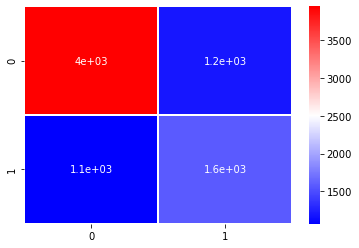

In [19]:
fit_decision_tree_classifier(X, y)

### Random Forest/Resampled Data

In [20]:
def fit_random_forest_classifier(X, y):
   
    #First let's create training and testing data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 46)

    clf = RandomForestClassifier(n_estimators=1000, max_depth=None)

    clf.fit(X_train, y_train)

    y_preds = clf.predict(X_test)

    mat = confusion_matrix(y_test, y_preds)
    print(mat)
    print(sns.heatmap(mat, annot=True, cmap='bwr', linewidths=.5))
    acc = accuracy_score(y_test, y_preds)
    print(acc)
    
    print('')
    cv_score = cross_val_score(clf, X, y, cv=10)
    print('*************CV Scores*************')
    print(cv_score)
    print(np.mean(cv_score))
    
    print('')
    print('Sensitivity-Specificity')
    tn, fp, fn, tp = confusion_matrix(y_test, y_preds).ravel()
    print(tn, fp, fn, tp)
    
    spec = tn/(tn+fp)
    sens = tp/(tp+fn)
    
    print(spec, sens)
    
    return acc

In [ ]:
fit_random_forest_classifier(X, y)

[[4845  306]
 [1174 1481]]
AxesSubplot(0.125,0.125;0.62x0.755)
0.8104022546758903

